# Multivariate Time Series Forecasting

## Overview

In this notebook, multiple forecasting algorithms are tried to predict the future price of steel. 

[1. Getting Started](#Getting_Started)

[2. Dataset](#Dataset)

[3. Metrics and Train/Test Split Functions](#Metrics)

[4. Pre-forecasting Analysis](#Pre-Analysis)

[5. ARIMA](#Arima)

[6. Holt-Winter's Seasonal Exponentional Smoothing](#Exponentional)

[7. VAR Model](#Var)

[8. Summary](#Summary)

[9. XGBoost](#Xgboost)

<a name="Getting_Started"></a>

## 1. Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from sklearn.model_selection import train_test_split
import xgboost as xgb
#import tscv
#from auto_ts import auto_timeseries
import statsmodels.api as sm

import sklearn.metrics
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [10, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a name="Dataset"></a>
## 2. Dataset
Here the dataset is imported and briefly explored.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ref_directory = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(ref_directory)
print('list of files:')
print(os.listdir(ref_directory))
print('='*100)

print('Uploading the .csv file >>>>>>>>>>>>>>>>>')
dataset_path = './Stainless-Steel-Prices-Forecasty-Assignment.csv'
df = pd.read_csv(dataset_path, index_col='Date', parse_dates=True )
print('='*100)

print('Dataset info:')
print(' ')
print("dataframe shape: " , df.shape)
print(' ')
df.info()

print('='* 100)
print(' ')
print('percentage of missing values in each column:')
null_percentage = df.isnull().sum() * 100 / len(df)
print(null_percentage)

print('='* 100)
print('number of distinct values per column:')
print(' ')
print(df.nunique())
print('='*100)
df.head()

list of files:
['colab', 'Stainless-Steel-Prices-Forecasty-Assignment.csv', 'steel_price_forecasting_1.ipynb']
Uploading the .csv file >>>>>>>>>>>>>>>>>
Dataset info:
 
dataframe shape:  (84, 19)
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2013-07-01 to 2020-06-01
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   StainlessSteelPrice       84 non-null     float64
 1   Steel_Inventory_M_USD     84 non-null     int64  
 2   Steel_Orders_M_USD        84 non-null     int64  
 3   IronOre_Global_USD        84 non-null     float64
 4   CoalAustralia_Global_USD  84 non-null     float64
 5   Energy_Index              84 non-null     float64
 6   Nickel_Global_USD         84 non-null     float64
 7   Zinc_Global_USD           84 non-null     float64
 8   Freight_Transport_Index   84 non-null     float64
 9   WTI_Crude_Global_USD      84 non-null     float64
 10  Baltic_Dry_Ind

,StainlessSteelPrice,Steel_Inventory_M_USD,Steel_Orders_M_USD,IronOre_Global_USD,CoalAustralia_Global_USD,Energy_Index,Nickel_Global_USD,Zinc_Global_USD,Freight_Transport_Index,WTI_Crude_Global_USD,Baltic_Dry_Index,BCI_China,BCI_Europe,BCI_US,CLI_China,CLI_Europe,CLI_US,PMI_US_Manufacturing,Copper_Global_USD
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,0.827352,20575,10568,127.191304,82.222360,227.022942,13750.31522,1837.619565,-0.4,104.545217,1062,98.80018,99.64265,100.1044,101.1423,99.43615,100.6230,50.9,6906.64
2013-08-01,0.760221,20609,10821,137.055000,82.221429,232.234194,14308.26190,1896.392857,0.5,106.546364,1132,99.04874,99.91766,100.3962,101.1938,99.64082,100.6545,55.4,7186.25
2013-09-01,0.784715,20761,10774,134.185714,83.295918,234.335594,13801.39286,1846.880952,0.1,106.313809,2003,99.27196,100.18490,100.5363,101.2066,99.84383,100.6646,55.7,7159.27
2013-10-01,0.769293,20735,11291,132.572727,85.443634,229.393932,14117.65217,1884.836957,-0.1,100.500435,1504,99.40488,100.36330,100.5771,101.1835,100.02300,100.6666,56.2,7203.02
2013-11-01,0.750242,20854,11559,136.323810,88.363265,225.437049,13684.01190,1866.416667,2.1,93.812381,1821,99.36221,100.49830,100.5459,101.1283,100.17150,100.6744,56.4,7070.65


So the dataframe has `19` columns and none of them have any missing values.
All `18` features are numerical;

Let's plot them to see their variations.


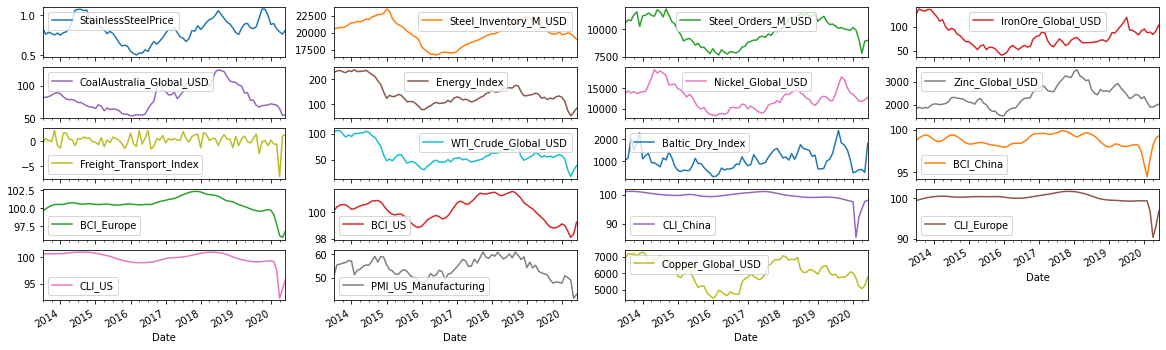

In [5]:
df.plot(figsize=(20,6), subplots=True, layout=(5,4));

<a name="Metrics"></a>
## 3. Metrics and Train/Test Split Functions
Here I defined the metric to use for comparing forecasting power of different 
algorithm. I used `SMAPE` as 
- it does not get infinite because of zero denominator
- is symmetric for under/over estimation
- more robust to extreme values (outliers)




In [4]:
# Set frequency
df = df.asfreq('MS') 
# Set target for forecasting
target = 'StainlessSteelPrice' 
# Set metric for forecasting quality comparision
metric = 'smape' # other options: 'rmse', 'mape', 'mae', 'mpe'

In [14]:
def forecast_accuracy(forecast, actual):
    """
    given 2 series calculates various forecasting metrics as a dictionary.
    """
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    smape = np.mean( 2 * np.abs(forecast - actual)/ (actual + forecast))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'smape':smape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [19]:
def train_test_df(df, train_len = 12, horizon = 3, fold = 5, fold_i = 1, growing_win = True):
    """
    splits a dataframe df into train/test.
    INPUTS:
        train_len: the number of samples in train dataframe for each fold ( when 'growing_win'=False)
        horizon: the number of samples in test dataframe for each fold 
        fold: number of folds
        fold_i: the counter indentifying each fold ( integer between 1 and 'fold')
        growing_win: whether or not to have sliding training set. if set to True the train dataframe always starts from the first index of 'df'
    OUTPUTS:
        two dataframes. first is train and the second is test
    """  
    test_end = horizon*(fold_i-1)
    test_start = test_end + horizon
    train_end = test_start
    if growing_win:
        train_start = len(df)
    else:
        train_start = train_end + train_len 
    train_df = df.copy().iloc[-train_start:-train_end,:]#[train_filt]
    if test_end ==0:
        test_df = df.copy().iloc[-test_start:,:] #[test_filt]
    else: 
        test_df = df.copy().iloc[-test_start:-test_end,:] #[test_filt]

    #print("train data shape :", train_df.shape[0] )
    #print("test data shape :", test_df.shape[0] )
    return train_df, test_df

<a name="Pre_Analysis"></a>
# 4. Pre-forecasting Analysis

First I try some decomposing to see how different components of the time-series are evovling.

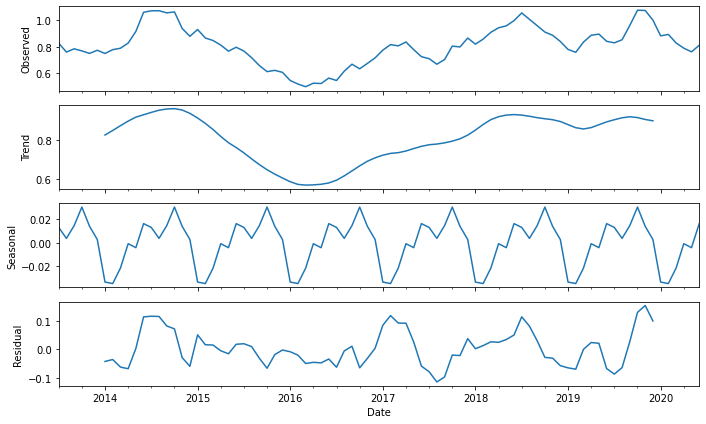

In [6]:
res = sm.tsa.seasonal_decompose(df[target],    )
plt.rcParams["figure.figsize"] = [10, 6]  # width, height
resplot = res.plot()

The main component is the trend with small seasonality. So the time series is not stationary.

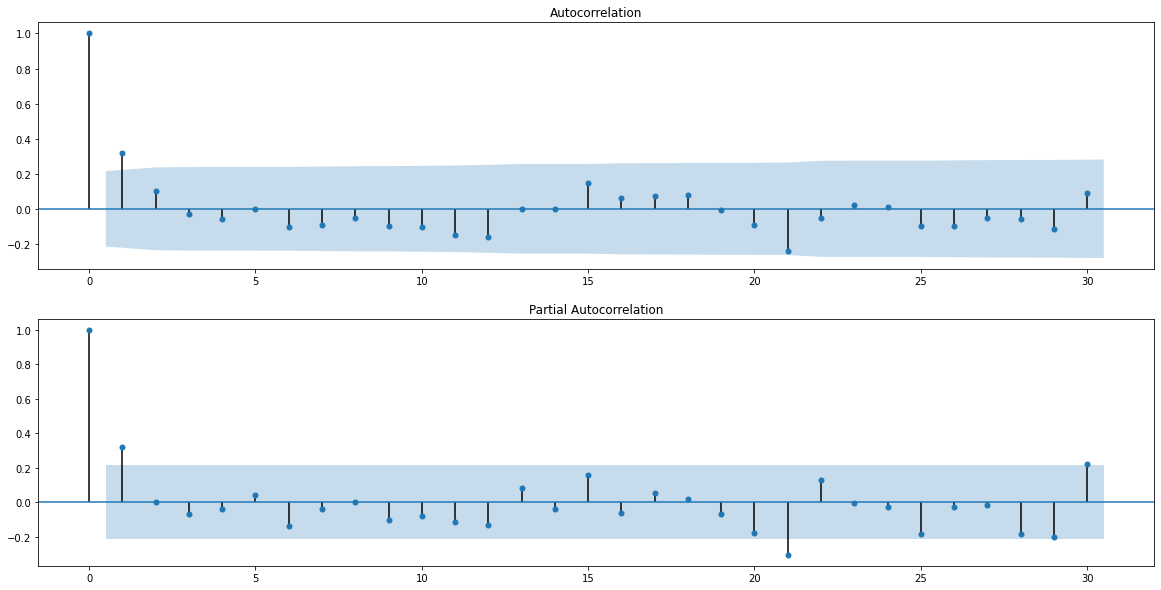

In [7]:
#we use df[target].diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df[target].diff().dropna(), lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df[target].diff().dropna(), lags=30, ax=ax[1])
plt.show()

The differenced target columns show up to 1st order auto-correlation which suggests p/q = 1 of the Arima model. Lets try to find the p/q order using the following functions.

In [8]:
print('using original data (without differencing)')
resDiff = sm.tsa.arma_order_select_ic(df[target], max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

using original data (without differencing)
ARMA(p,q) = (2, 0) is the best.


In [9]:
print('using differenced data (with differencing)')
resDiff = sm.tsa.arma_order_select_ic(df[target].diff().dropna(), max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

using differenced data (with differencing)
ARMA(p,q) = (1, 0) is the best.


<a name="Arima"></a>
# 5. ARIMA

As the first step in forecsting, I start from ARIMA model to give us a baseline for future forecasting improvement. Based on above analysis I used `(p,d,q)=(1,1,0)` without any seasoning (I tried with seasoning but the resuld did not improved as the decomposition results suggests).

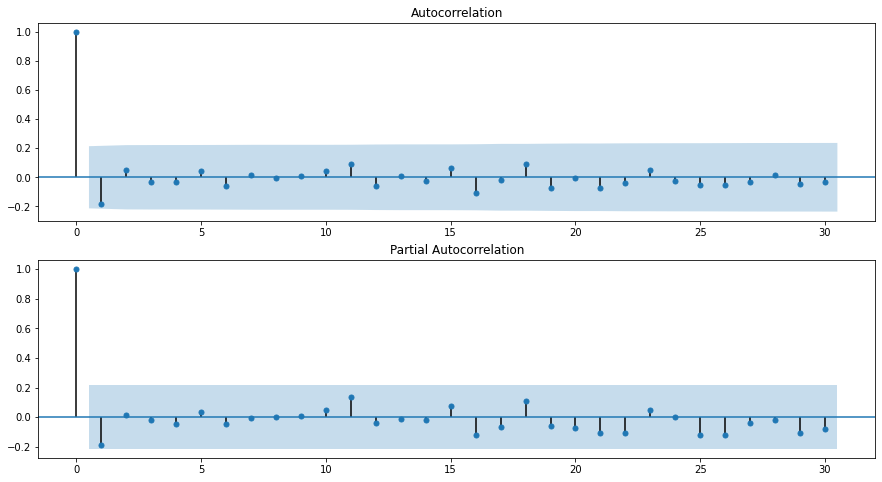

In [13]:
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .
arima = sm.tsa.statespace.SARIMAX(df[target],order=(1,1,0),freq='MS',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()

res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

This model's resid have few autocorrelation.
It means that We were able to make a good model.

Below I defined two function to do cross-validation on the forecasting results from ARIMA model.


In [24]:
def run_arima(train_df,horizon, target, pdq = (1,1,0)):
    """
    Runs Arima model on the 'target' column in 'train_df' dataframe and 
    returns multiple ('horizon') steps ahead predictions
    """
    model =  sm.tsa.statespace.SARIMAX(train_df[target],order=pdq,freq='MS',seasonal_order=(0,0,0,0),
                              enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit()
    pred = fit.forecast(horizon)
    return pred
  
def run_arima_cv(df,horizon, num_folds, train_length, target,pdq = (1,1,0), metric='smape', plot = False, growing_win=True):
    """
    Runs cross-validation forecasting using Arima model
    INPUTS:
        df = dataframe to perform analysis
        horizon = number of steps ahead to predict
        num_folds = number of folds for the cross validation
        train_length = the number of samples in train dataframe of each fold
        target = the columns name of the target to predict
        pdq = the order of ARIMA model
        metric = the metric to return representing the performance of the crossvalidated forecasting
        plot = whether or not to plot the prediction vs reality of each fold
        growing_wing = whether or not to use sliding window cross validation
    OUTPUTS:
        the mean of the performance metric over all folds
    """
    cv_metrics = []
    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(df, train_len = train_length, horizon = horizon, fold = num_folds, fold_i = i, growing_win=growing_win)
        pred = run_arima(train_df, horizon=horizon, target=target, pdq =pdq)
        
        metrics = forecast_accuracy(pred, test_df[target])
        train_test = pd.concat([train_df[target] , test_df[target]], axis=0)
        #print('fold ' + str(i))
        #print(metrics)
        cv_metrics.append(metrics[metric])
        if plot:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(train_test.index, train_test.values, label='truth');
            ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label= metric + " ={:0.2f})".format(metrics[metric]));
            ax.legend();
            ax.set_title("ARIMA order: "+ str(pdq) + ' fold # ' + str(i) );
    final = str(np.mean(cv_metrics))
    #print('average cross validated'+ metric + ' for ARIMA '+ str(pdq)+' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ', final ) 
    return final

In [21]:
print('3-steps ahead forecasting')
pdq = (1,1,0)
_= run_arima_cv(df,horizon=3, num_folds=15, train_length=24, target=target,pdq = pdq, metric=metric, plot = False, growing_win=True)
print('average cross validated '+ metric + ' for ARIMA '+ str(pdq)+' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ', _ )
pdq =(2,1,0)
_= run_arima_cv(df,horizon=3, num_folds=15, train_length=24, target=target,pdq = (2,1,0), metric=metric, plot = False, growing_win=True)
print('average cross validated '+ metric + ' for ARIMA '+ str(pdq)+' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ', _ )

print('3-steps ahead forecasting even sliding window')
_= run_arima_cv(df,horizon=3, num_folds=15, train_length=24, target=target,pdq = (2,1,0), metric=metric, plot = False, growing_win=False)
print('average cross validated '+ metric + ' for ARIMA '+ str(pdq)+' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ', _ )

3-steps ahead forecasting
average cross validated smape for ARIMA (1, 1, 0) is >>>>>>>>>>>>>>>>>>>>>>>>>>>>  0.059385399307299004
average cross validated smape for ARIMA (2, 1, 0) is >>>>>>>>>>>>>>>>>>>>>>>>>>>>  0.05838068072648609
3-steps ahead forecasting even windowing
average cross validated smape for ARIMA (2, 1, 0) is >>>>>>>>>>>>>>>>>>>>>>>>>>>>  0.056078263666315444


I tried 3 differenct setting to see which gives me the lowest `smape`.
 ARIMA ``` (2,1,0)``` with constant size training window in each fold has the lowest crossvalidated ```SMAPE```. The `train_length` is optimized in the next part to find the lowest `SMAPE` for ARIMA model. 





Min smape corresponds to training window length of >>>>>>>>>>>  25
with corresponding metric of >>>>>>>>>>>>> 0.0560131289856983


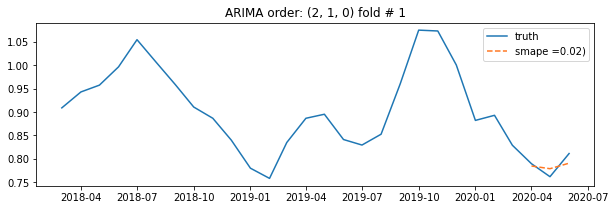

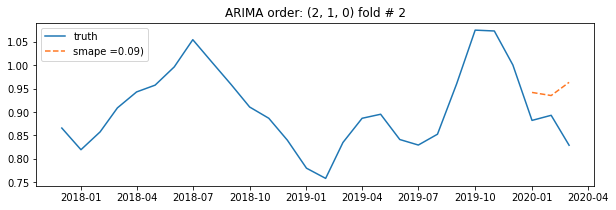

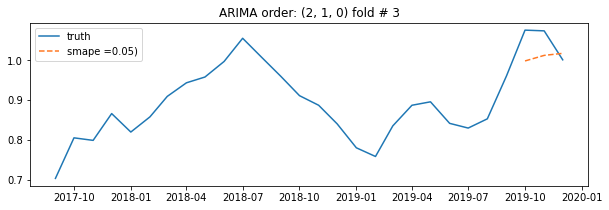

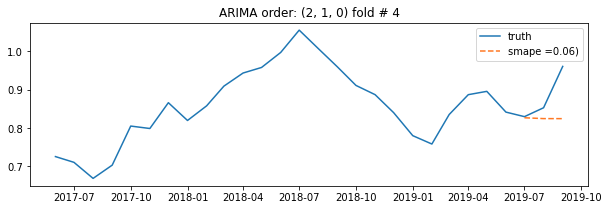

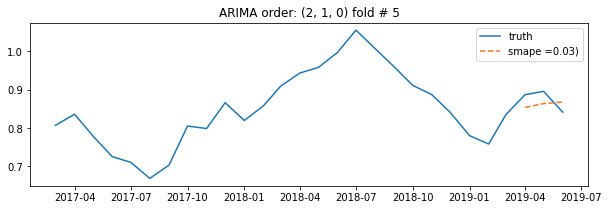

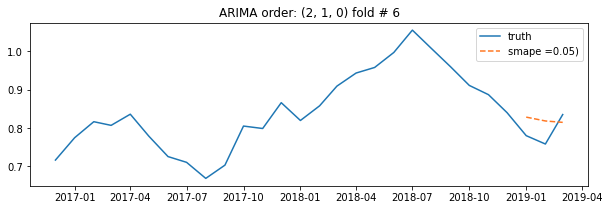

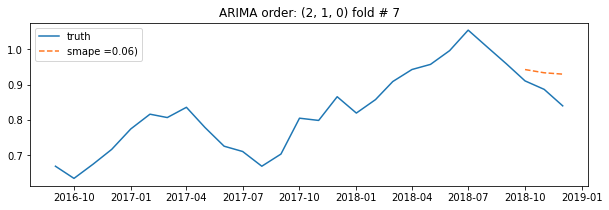

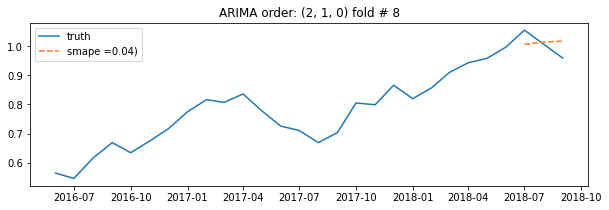

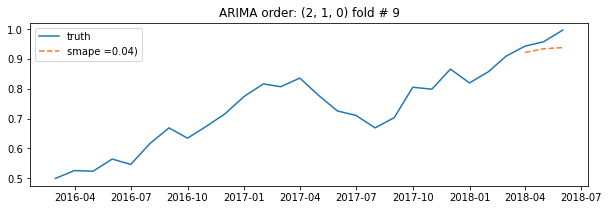

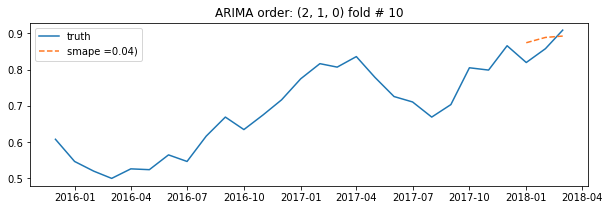

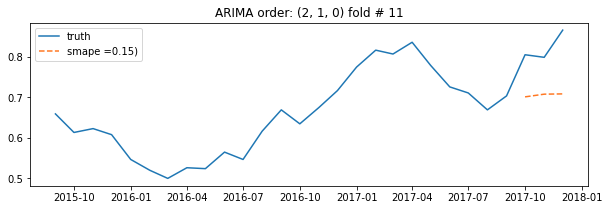

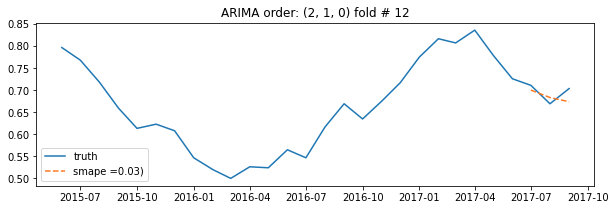

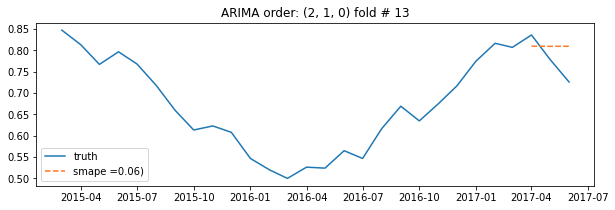

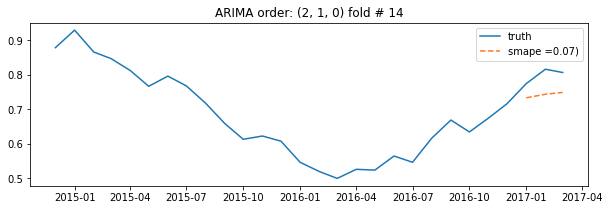

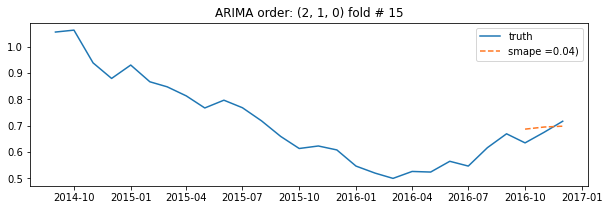

In [25]:
metrics_list= []
train_win_list = [l for l in range(10, 30)]
for length in train_win_list:
#    print('training window length: >>>>>>>>', str(length))
    _= run_arima_cv(df,horizon=3, num_folds=15, train_length=length, target=target,pdq = (2,1,0), metric=metric, plot = False, growing_win=False)
    metrics_list.append(_)

LENGTH = train_win_list[ np.argmin(metrics_list)]
print("\nMin "+ metric+ " corresponds to training window length of >>>>>>>>>>> ", LENGTH )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )
# lets plot the forecasting result
_ =run_arima_cv(df,horizon=3, num_folds=15, train_length=LENGTH, target=target,pdq = (2,1,0), metric=metric, plot = True, growing_win=False)

**So the lowest ```SMAPE``` for ARIMA model is ```0.05601``` which corresponds to ```ARIMA(2,1,0)``` with constant training window length of  ```25```.**


<a name="Exponentional"></a>

# 6. Holt-Winter's Seasonal Smoothing

The Holt Winter’s Exponential Smoothing also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account. The method is suitable for univariate time series with trend and/or seasonal components.


In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def run_ExpSmoothing(train_df, horizon, target, damped, seasonality= False):
    """
    Runs exponentional smooting model on the 'target' column in 'train_df' dataframe and 
    returns multiple ('horizon') steps ahead predictions
    """

    model = ExponentialSmoothing(train_df[target].values, trend="add", damped=damped)
    if seasonality:
        model = ExponentialSmoothing(train_df[target].values, trend="add", seasonal="add", seasonal_periods=12, damped=damped)
    fit = model.fit()
    pred = fit.forecast(horizon)
    return pred

def run_ExpSmoothing_cv(df,horizon, num_folds, train_length,damped, target, metric='smape', plot = False, seasonality= False,growing_win=True):
    """
    Runs cross-validation forecasting using exponentional smoothing model
    INPUTS:
        df = dataframe to perform analysis
        horizon = number of steps ahead to predict
        num_folds = number of folds for the cross validation
        train_length = the number of samples in train dataframe of each fold
        damped = whether or not to set the damping parameter in the model to True
        target = the columns name of the target to predict
        seasonality = whether to add seasonality to the model or not
        metric = the metric to return representing the performance of the crossvalidated forecasting
        plot = whether or not to plot the prediction vs reality of each fold
        growing_wing = whether or not to use sliding window cross validation
    OUTPUTS:
        the mean of the performance metric over all folds
    """
    cv_metrics = []
    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(df, train_len = train_length, horizon = horizon, fold = num_folds, fold_i = i, growing_win=growing_win)
        pred = run_ExpSmoothing(train_df, horizon=horizon, target=target, damped=damped, seasonality= seasonality)

        metrics = forecast_accuracy(pred, test_df[target])
        train_test = pd.concat([train_df[target] , test_df[target]], axis=0)
        #print('fold ' + str(i))
        #print(metrics)
        cv_metrics.append(metrics[metric])
        if plot:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(train_test.index, train_test.values, label='truth');
            ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label= metric + " ={:0.2f})".format(metrics[metric]));
            ax.legend();
            ax.set_title("Holt-Winter's Seasonal Smoothing" + ' fold # ' + str(i));
    final = str(np.mean(cv_metrics) )
    #print('average cross validated '+ metric + ' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ' , final )
    return(final)

In [31]:
_ = run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_length=25, damped=True, target=target, metric=metric, plot = False, seasonality = True, growing_win=True)
print('average cross validated '+ metric + ' for ExpSmoothing (3-steps ahead, WITH seasonality, expanding traing window) is >>>>>>>>>>>>>>>>>>>> ')
print(_)
_ = run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_length=25, damped=True, target=target, metric=metric, plot = False, seasonality = False, growing_win=True)
print('average cross validated '+ metric + ' for ExpSmoothing (3-steps ahead, WITHOUT seasonality, expanding traing window) is >>>>>>>>>>>>>>>>>>> ')
print(_)
_ = run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_length=25, damped=True, target=target, metric=metric, plot = False, seasonality = False, growing_win=False)
print('average cross validated '+ metric + ' for ExpSmoothing (3-steps ahead, WITHOUT seasonality, constant training window length) is >>>>>>>>>>>>>>>>>>> ')
print(_)

average cross validated smape for ExpSmoothing (3-steps ahead, WITH seasonality, expanding traing window) is >>>>>>>>>>>>>>>>>>>> 
0.09931045717867552
average cross validated smape for ExpSmoothing (3-steps ahead, WITHOUT seasonality, expanding traing window) is >>>>>>>>>>>>>>>>>>> 
0.05977986635397533
average cross validated smape for ExpSmoothing (3-steps ahead, WITHOUT seasonality, constant training window length) is >>>>>>>>>>>>>>>>>>> 
0.06013837224163356


So the result without seasonality is much better. I tried both `damped = True` and `False` and with damping the error was smaller so I just kept `damped = True`. The `growing_win = True` is performing slightly better here. But once I optimize the `train_length` parameter below, `growing_win = False` performed better so I just kept this setting in the following part. 

In [33]:
metrics_list= []
train_win_list = [l for l in range(10, 30)]
for length in train_win_list:
#    print('training window length: >>>>>>>>', str(length))
    _ = run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_length=length, damped=True, target=target, metric=metric, plot = False, seasonality = False, growing_win=False)
    metrics_list.append(_)
LENGTH = train_win_list[ np.argmin(metrics_list)]
print("\nMin "+ metric+ " corresponds to training window length of >>>>>>>>>>> ", LENGTH )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )


Min smape corresponds to training window length of >>>>>>>>>>>  24
with corresponding metric of >>>>>>>>>>>>> 0.05869725043021468


lets plot the forecasting results for the optimized setting:


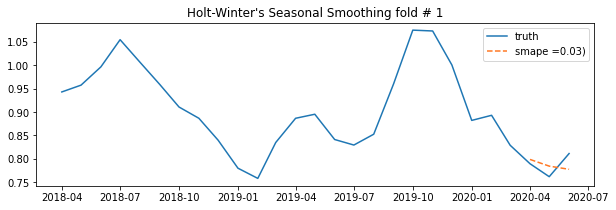

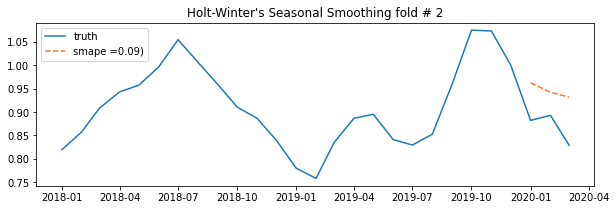

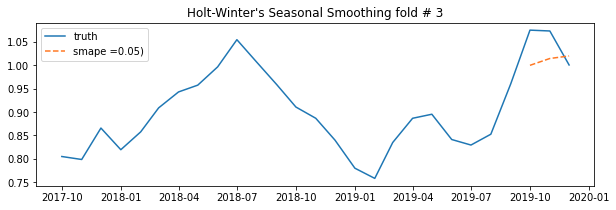

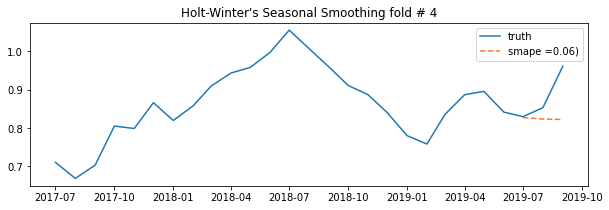

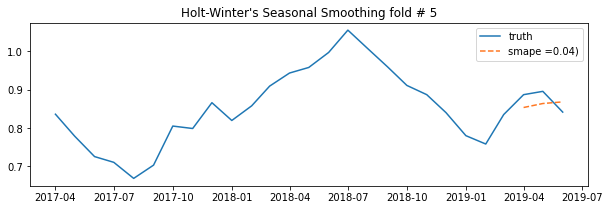

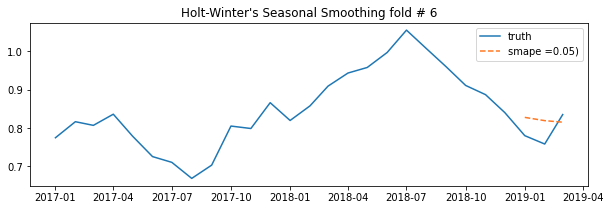

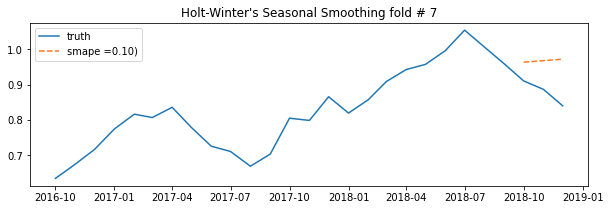

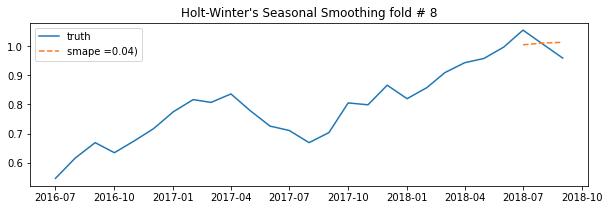

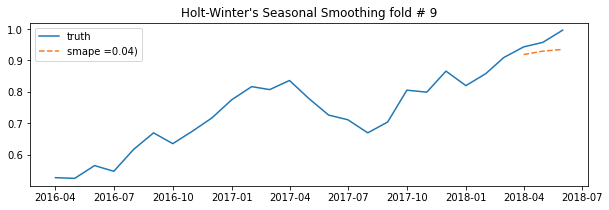

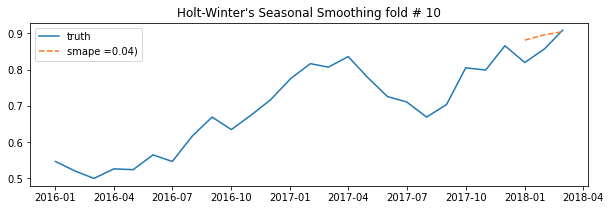

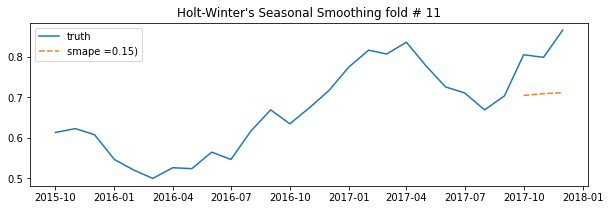

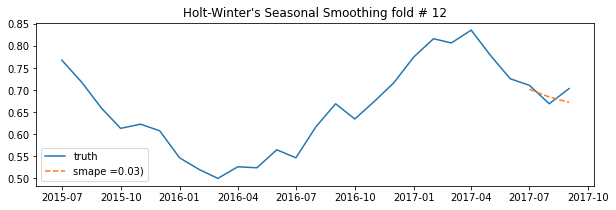

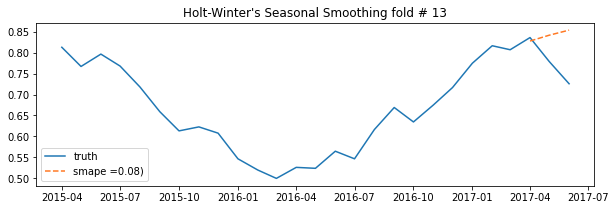

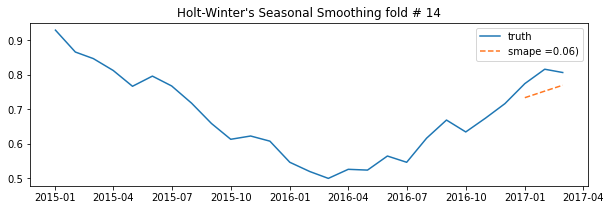

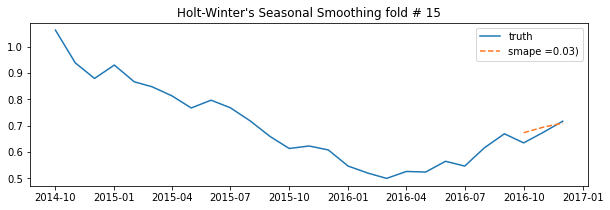

In [34]:
print('lets plot the forecasting results for the optimized setting:')
_=run_ExpSmoothing_cv(df,horizon=3, num_folds=15, train_length=LENGTH, damped=True, target=target, metric=metric, plot = True, seasonality = False, growing_win=False)


**So the lowest ```SMAPE``` for Holt-Winter's Seasonal Smoothing model is ```0.058697``` which corresponds to no seasonality and with equal training window of length ```24```. This result is slightly worse than ARIMA model above.**

<a name="Var"></a>

# 7. VAR Model

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

<a name="Exponentional"></a>

## 7.1. Testing Causation using Granger’s Causality Test


Using Granger’s Causality Test, it’s possible to test the relationships between the various timeseries in the system before even building the VAR model.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

The below code implements the Granger’s Causality test for all possible combinations of the time series in a given dataframe and stores the p-values of each combination in the output matrix.

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False,)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_result =grangers_causation_matrix(df, variables = df.columns)  
granger_result

,StainlessSteelPrice_x,Steel_Inventory_M_USD_x,Steel_Orders_M_USD_x,IronOre_Global_USD_x,CoalAustralia_Global_USD_x,Energy_Index_x,Nickel_Global_USD_x,Zinc_Global_USD_x,Freight_Transport_Index_x,WTI_Crude_Global_USD_x,Baltic_Dry_Index_x,BCI_China_x,BCI_Europe_x,BCI_US_x,CLI_China_x,CLI_Europe_x,CLI_US_x,PMI_US_Manufacturing_x,Copper_Global_USD _x
StainlessSteelPrice_y,1.0000,0.1204,0.0001,0.0131,0.0520,0.0183,0.0000,0.0001,0.4200,0.0032,0.0324,0.0139,0.1156,0.1097,0.1056,0.5341,0.2803,0.1909,0.0000
Steel_Inventory_M_USD_y,0.0000,1.0000,0.0000,0.0101,0.0000,0.0000,0.0004,0.0000,0.0002,0.0000,0.0003,0.0001,0.0001,0.0000,0.0995,0.0001,0.0000,0.0000,0.0000
Steel_Orders_M_USD_y,0.0000,0.0079,1.0000,0.0313,0.0016,0.0000,0.0000,0.0054,0.0001,0.0000,0.0152,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0000
IronOre_Global_USD_y,0.0391,0.0802,0.2258,1.0000,0.0196,0.2834,0.0179,0.0267,0.0292,0.2697,0.0109,0.0093,0.1046,0.0003,0.0965,0.0000,0.0039,0.0005,0.4108
CoalAustralia_Global_USD_y,0.0367,0.0041,0.0368,0.0060,1.0000,0.1839,0.2175,0.0033,0.0003,0.2017,0.5499,0.0195,0.0001,0.0000,0.0952,0.0039,0.0219,0.0065,0.0316
Energy_Index_y,0.0000,0.0250,0.0699,0.2774,0.0703,1.0000,0.0000,0.2087,0.0396,0.0057,0.1240,0.0000,0.0053,0.0025,0.0000,0.0449,0.0638,0.0039,0.0558
Nickel_Global_USD_y,0.0274,0.0225,0.0000,0.0016,0.0548,0.0071,1.0000,0.1179,0.4878,0.0067,0.0800,0.2350,0.0407,0.3486,0.1977,0.7652,0.1509,0.1722,0.0083
Zinc_Global_USD_y,0.0003,0.0001,0.0000,0.3818,0.2035,0.0116,0.0002,1.0000,0.1058,0.0379,0.4791,0.0004,0.1751,0.0047,0.0177,0.4257,0.0000,0.0171,0.0011
Freight_Transport_Index_y,0.0497,0.0026,0.0015,0.0054,0.1265,0.0001,0.0407,0.0092,1.0000,0.0001,0.0193,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0166,0.0213
WTI_Crude_Global_USD_y,0.0000,0.0713,0.2111,0.1844,0.1559,0.0001,0.0000,0.1195,0.0696,1.0000,0.0961,0.0000,0.0324,0.0060,0.0000,0.0135,0.0021,0.0027,0.0690


In [52]:
mask = granger_result.loc['StainlessSteelPrice_y',:] > 0.15
not_causing_features = granger_result.loc[:,mask].columns.values[1:].tolist()
not_causing_features =[col.split('_x')[0] for col in not_causing_features]
print('These columns have p-value larger than 0.15. so we cannot reject the null that they cause "StainlessSteelPrice" :')
print('-'*150)
for column in not_causing_features:
    print(column)

These columns have p-value larger than 0.15. so we cannot reject the null that they cause "StainlessSteelPrice" :
------------------------------------------------------------------------------------------------------------------------------------------------------
Freight_Transport_Index
CLI_Europe
CLI_US
PMI_US_Manufacturing


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0001 at (row 1, column 3) represents the p-value of the Grangers Causality test for ```Steel_Orders_M_USD_x``` causing ```StainlessSteelPrice_y```, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude ```Steel_Orders_M_USD``` causes ```StainlessSteelPrice```.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.


## 7.2. Augmented Dickey-Fuller Test:

Before fitting the VAR model, I test for stationarity of all columns in the dataset:

In [36]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    #print(f' Test Statistic        = {output["test_statistic"]}')
    #print(f' No. Lags Chosen       = {output["n_lags"]}')

    #for key,val in r[4].items():
    #    print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [37]:
# ADF Test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "StainlessSteelPrice" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.1574. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Steel_Inventory_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0126. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Orders_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.2353. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IronOre_Global_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has un

So there are many columns that are not stationary.
Below I did 1st difference on all columns and re-did  ADF test.

In [38]:
# 1st difference
df_differenced = df.diff().dropna()
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "StainlessSteelPrice" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Inventory_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Steel_Orders_M_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 => P-Value = 0.0002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IronOre_Global_USD" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

Still few columns are not stationary but the majority are (I tested 2nd differencing but again few were non-stationary so I stick with 1st differencing. 

## 7.3. Lag Order:

Here I briefly fitted the 1-st differenced dataframe with different lag values of VAR model and reported `AIC/BIC` criteria to get and idea of what lag setting will work for our VAR model.

In [39]:
model = VAR(df.diff().dropna())
for i in range(1,13):
    result = model.fit(i)
    print('Lag Order =', i)
    try:
      print('AIC : ', result.aic)
      print('BIC : ', result.bic)
      print('HQIC: ', result.hqic, '\n')
    except:
      pass

Lag Order = 1
AIC :  49.37903088143659
BIC :  60.53212007607581
HQIC:  53.856825553184166 

Lag Order = 2
AIC :  40.821920245588885
BIC :  62.726695845740466
HQIC:  49.610403254325014 

Lag Order = 3
AIC :  26.595512781007024
BIC :  59.40792967363974
HQIC:  39.75094962924115 

Lag Order = 4
Lag Order = 5
AIC :  -945.3974248856672
BIC :  -890.2866954000028
HQIC:  -923.3355875811916 

Lag Order = 6
AIC :  -998.8539110932066
BIC :  -932.3446273691768
HQIC:  -972.2507818858335 

Lag Order = 7
AIC :  -1020.1208661757132
BIC :  -942.0412992761211
HQIC:  -988.9164945238113 

Lag Order = 8
AIC :  -1035.750158665635
BIC :  -945.9243193849675
HQIC:  -999.8836873993029 

Lag Order = 9
AIC :  -1042.204031449772
BIC :  -940.4515351715122
HQIC:  -1001.61370967708 

Lag Order = 10
AIC :  -1046.4799854164007
BIC :  -932.6159126502704
HQIC:  -1001.1031858594695 

Lag Order = 11
AIC :  -1058.8158350141869
BIC :  -932.6505875853804
HQIC:  -1008.5890764031662 

Lag Order = 12
AIC :  -1059.9432285200053
BI

The `BIC` suggest lag values should be within `7-10` range.

A common way of checking different lags is by Durbin Watson’s Statistic. In the following, the serial correlation of errors are measured using this test.
The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

With lag of `9` the test statistics are closer to `2`. So a lag around `9` should be valid for our VAR model. I try to optimize it using the cross-validated `SMAPE`. 

In [40]:
from statsmodels.stats.stattools import durbin_watson

model = VAR(df.diff().dropna())
model_fitted = model.fit(9)
#model_fitted.summary()
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

StainlessSteelPrice : 1.05
Steel_Inventory_M_USD : 1.86
Steel_Orders_M_USD : 1.91
IronOre_Global_USD : 1.6
CoalAustralia_Global_USD : 1.88
Energy_Index : 1.85
Nickel_Global_USD : 1.56
Zinc_Global_USD : 1.66
Freight_Transport_Index : 1.54
WTI_Crude_Global_USD : 1.66
Baltic_Dry_Index : 1.43
BCI_China : 2.06
BCI_Europe : 1.66
BCI_US : 1.25
CLI_China : 1.89
CLI_Europe : 1.69
CLI_US : 1.39
PMI_US_Manufacturing : 1.19
Copper_Global_USD  : 2.1


## 7.4. VAR Model

In [41]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast in original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    
    df_fc.drop(columns = [col for col in df_fc.columns if 'forecast' not in col] , inplace = True, axis = 1)
    return df_fc

In [43]:
def run_VAR_model(train_df, diff_order, maxlag, horizon, target = 'StainlessSteelPrice'):
    """
    Runs VAR model on the 'target' column in 'train_df' dataframe and 
    returns multiple ('horizon') steps ahead predictions
    """
    # Input data for forecasting
    if diff_order == 1:
        model = VAR(train_df.diff().dropna())    
        model_fitted = model.fit( maxlag)
        # Get the lag order
        lag_order = model_fitted.k_ar
        forecast_input = train_df.diff().dropna().values#[-lag_order:]
    if diff_order == 2:
        model = VAR(train_df.diff().diff().dropna())    
        model_fitted = model.fit( maxlag)
        # Get the lag order
        lag_order = model_fitted.k_ar
        forecast_input = train_df.diff().diff().dropna().values#[-lag_order:]
    
    fc = model_fitted.forecast(y=forecast_input, steps=horizon)
    df_forecast = pd.DataFrame(fc, columns=train_df.columns + '_' + str(diff_order) + 'd')
    if diff_order == 1:
        df_results = invert_transformation(train_df, df_forecast, second_diff=False)        
    if diff_order == 2:
        df_results = invert_transformation(train_df, df_forecast, second_diff=True)

    y_hat = df_results[target+'_forecast']
    return y_hat.values

def run_VAR_cv(df,horizon, num_folds, train_length, lag, diff, target, metric='smape', plot = False, growing_win=True):
    """
    Runs cross-validation forecasting using VAR model
    INPUTS:
        df = dataframe to perform analysis
        horizon = number of steps ahead to predict
        num_folds = number of folds for the cross validation
        train_length = the number of samples in train dataframe of each fold
        lag = the maximum lag of the VAR model
        diff = the differencing order (1 or 2)
        target = the columns name of the target to predict
        metric = the metric to return representing the performance of the crossvalidated forecasting
        plot = whether or not to plot the prediction vs reality of each fold
        growing_wing = whether or not to use sliding window cross validation
    OUTPUTS:
        the mean of the performance metric over all folds
        the metric for individual test points during cross validation. this is used to get
        the distribution of the errors for estimating the confidence interval of our forcasting.
    """
    cv_metrics = []
    single_metrics = []
    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(df, train_len = train_length, horizon = horizon, fold = num_folds, fold_i = i, growing_win=growing_win)
        pred = run_VAR_model(train_df, diff_order=diff, maxlag=lag, horizon = horizon, target=target)
        metrics = forecast_accuracy(pred, test_df[target])
        
        for i,p in enumerate(pred):
            m = forecast_accuracy(pred[i], test_df[target].iloc[i])[metric]
            single_metrics.append(m)

        train_test = pd.concat([train_df[target] , test_df[target]], axis=0)
        #print('fold ' + str(i))
        #print(metrics)
        cv_metrics.append(metrics[metric])
        if plot:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(train_test.index, train_test.values, label='truth');
            ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label= metric + " ={:0.2f})".format(metrics[metric]));
            ax.legend();
            ax.set_title("VAR" + ' fold # ' + str(i));
        Mean = np.mean(cv_metrics)
        #SD = np.var(cv_)
    #print('average cross validated '+ metric + ' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ' , str( final ) )
    return Mean, single_metrics

In [47]:
print('optimizing the maxlag parameter of the VAR model: ')
metrics_list= []
lag_list = [l for l in range(1, 10)]
for maxlag in lag_list:
    #print('maxlag = ', str(maxlag))
    m,l = run_VAR_cv(df,horizon=3, num_folds=15, train_length=24, lag=maxlag, diff=1, target = target, metric=metric, plot = False, growing_win=False)
    metrics_list.append(m)
print("\nMin "+ metric+ " corresponds to MaxLag of >>>>>>>>>>> ", lag_list[ np.argmin(metrics_list)] )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )
LAG = lag_list[ np.argmin(metrics_list)]

optimizing the maxlag parameter of the VAR model: 

Min smape corresponds to MaxLag of >>>>>>>>>>>  8
with corresponding metric of >>>>>>>>>>>>> 0.06572338685414099


In [48]:
print('optimizing the training window length: ')
metrics_list = []
train_win_list = [l for l in range(12, 30)]
for length in train_win_list:
    #print('train window length: ', str(length))
    m,l = run_VAR_cv(df,horizon=3, num_folds=15, train_length= length, lag=LAG, diff=1, target = target, metric=metric, plot = False, growing_win=False)
    metrics_list.append(m)
print("\nMin "+ metric+ " corresponds to training window length of >>>>>>>>>>> ", train_win_list[ np.argmin(metrics_list)] )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )

optimizing the training window length: 

Min smape corresponds to training window length of >>>>>>>>>>>  15
with corresponding metric of >>>>>>>>>>>>> 0.054053411873609694


In [50]:
print('expanding training window VS. constant size sliding windwo:')
TRAIN_LEN = train_win_list[ np.argmin(metrics_list)]
print('average cross validated '+ metric + ' for VAR (3-steps ahead, expanding training window) is >>>>>>>>>>>>>>>>>>> ')
m,l= run_VAR_cv(df,horizon=3, num_folds=15, train_length= TRAIN_LEN, lag=LAG, diff=1, target = target, metric=metric, plot = False, growing_win=True)
print(m)
print('average cross validated '+ metric + ' for VAR (3-steps ahead, even training window) is >>>>>>>>>>>>>>>>>>> ')
m, l= run_VAR_cv(df,horizon=3, num_folds=15, train_length= TRAIN_LEN, lag=LAG, diff=1, target = target, metric=metric, plot = False, growing_win=False)
print(m)

expanding training window VS. constant size sliding windwo:
average cross validated smape for VAR (3-steps ahead, expanding training window) is >>>>>>>>>>>>>>>>>>> 
0.1826251786380905
average cross validated smape for VAR (3-steps ahead, even training window) is >>>>>>>>>>>>>>>>>>> 
0.054053411873609694


In [55]:
print('keeping all columns vs. dropping some of non-causal columns')
print('average cross validated '+ metric + ' for VAR (3-steps ahead, even training window, full dataframe) is >>>>>>> ')
m, l= run_VAR_cv(df,horizon=3, num_folds=15, train_length= TRAIN_LEN, lag=LAG, diff=1, target = target, metric=metric, plot = False, growing_win=False)
print(m)

print('average cross validated '+ metric + ' for VAR (3-steps ahead, even training window, filtered dataframe) is >>>>>>> ')
filtered_df = df[[i for i in df.columns if i not in not_causing_features]]
print('after dropping uncausing features >>>>>',not_causing_features)
m,cv_metric_list= run_VAR_cv(filtered_df,horizon=3, num_folds=15, train_length=TRAIN_LEN, lag= LAG, diff=1, target = target, metric=metric, plot = False, growing_win=False)
print(m)

keeping all columns vs. dropping some of non-causal columns
average cross validated smape for VAR (3-steps ahead, even training window, full dataframe) is >>>>>>> 
0.054053411873609694
average cross validated smape for VAR (3-steps ahead, even training window, filtered dataframe) is >>>>>>> 
after dropping uncausing features >>>>> ['Freight_Transport_Index', 'CLI_Europe', 'CLI_US', 'PMI_US_Manufacturing']
0.05405359055891696


Therefore dropping the `none-causal` columns found from `Granger’s Causality Test` does not significanlty reduce the performance of the model which makes sence based on the test results.  ( i.e. dropping ```'Freight_Transport_Index', 'CLI_Europe', 'CLI_US', 'PMI_US_Manufacturing'``` does not influence the VAR forecasting metric and we can safely drop them for forecasting.)

lets plot the forecasting results for the optimized setting:
3-steps ahead forecasting with even-windowing, dropping non-causal columns
0.05405359055891696


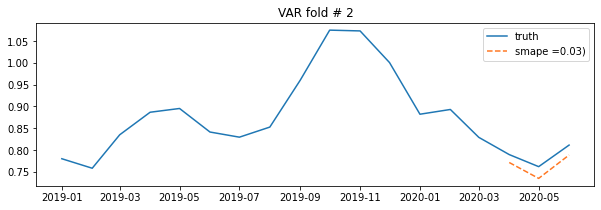

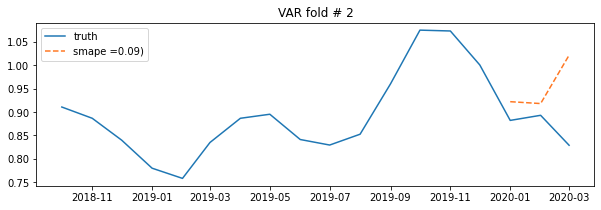

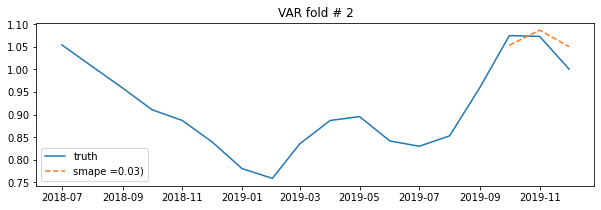

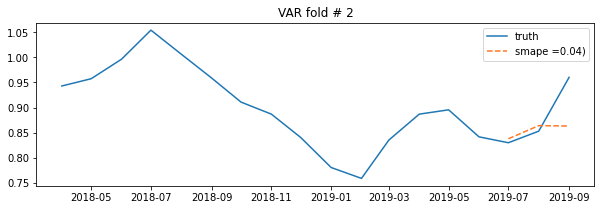

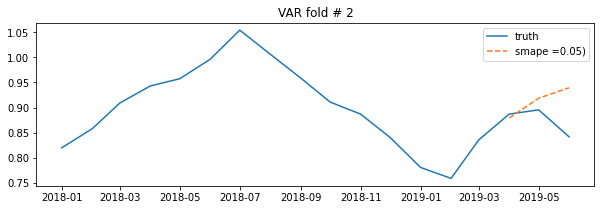

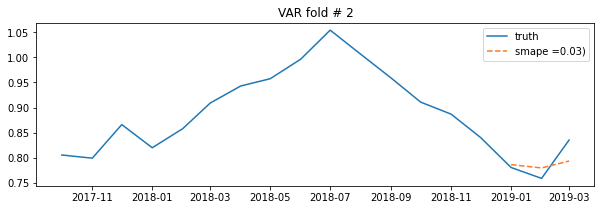

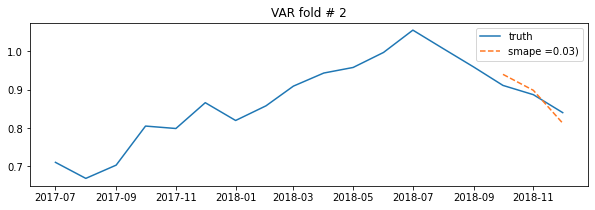

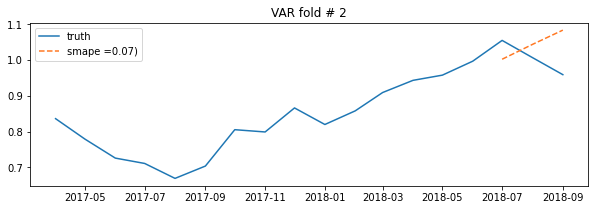

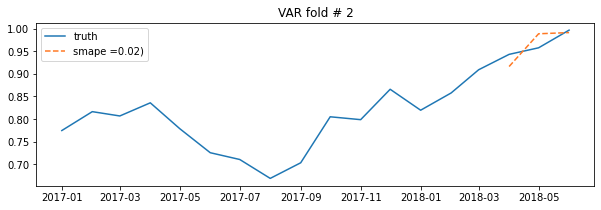

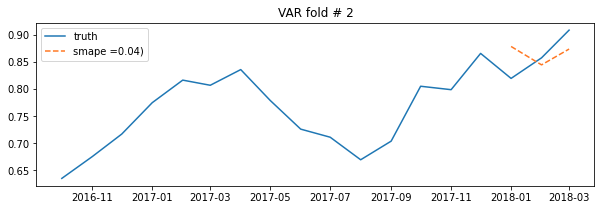

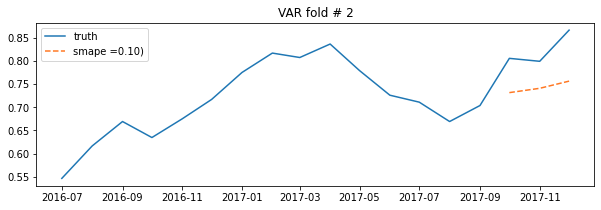

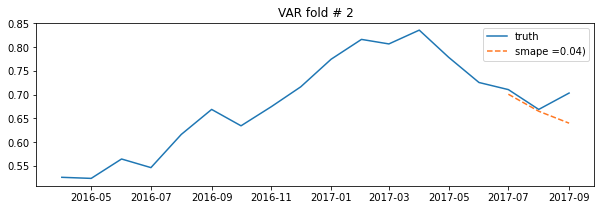

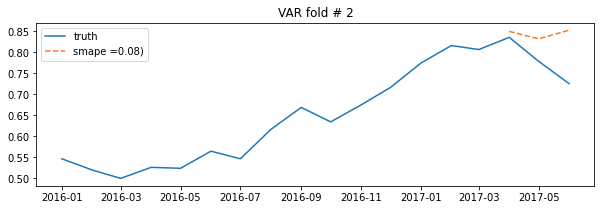

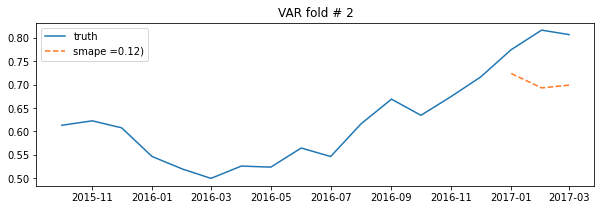

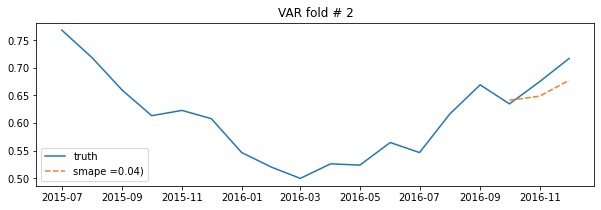

In [57]:
print('lets plot the forecasting results for the optimized setting:')

print('3-steps ahead forecasting with even-windowing, dropping non-causal columns')
m,cv_metric_list= run_VAR_cv(filtered_df,horizon=3, num_folds=15, train_length=TRAIN_LEN, lag= LAG, diff=1, target = target, metric=metric, plot = True, growing_win=False)
print(m)

**The lowest ```SMAPE``` for VAR model is ```0.05405``` which corresponds to maxium lag of ```8``` and with equal training window of length ```24```.**

## 7.5. VAR Forecasts's Confidence Interval

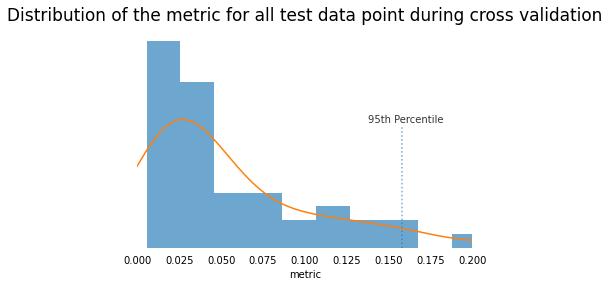

In [59]:
fig, ax = plt.subplots(figsize = (6,4))
avocado = pd.Series(cv_metric_list)
# Plot histogram
avocado.plot(kind = "hist", density = True, alpha = 0.65) # change density to true, because KDE uses density
# Plot KDE
avocado.plot(kind = "kde")
# Quantile lines
quant_95 = avocado.quantile(0.95)
quants = [ [quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")
# X
ax.set_xlabel("metric")
x_start, x_end = 0, 0.2
ax.set_xlim(x_start, x_end)
# Y
ax.set_yticklabels([])
ax.set_ylabel("")
# Annotations
ax.text(quant_95-0.02, 10, "95th Percentile", size = 10, alpha =.8)
# Overall
ax.grid(False)
ax.set_title("Distribution of the metric for all test data point during cross validation", size = 17, pad = 10)
# Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)  
plt.show()

In [60]:
def add_uncertainty(y_hat, smape):
    """
    calculates the confidence interval for a prediction given the average 'smape' metric.
    """
    y_lower = y_hat*(1-smape/2)/(1+smape/2)
    y_upper = y_hat*(1+smape/2)/(1-smape/2)
    output = pd.DataFrame({'y_hat': y_hat, 'y_lower':y_lower, 'y_upper':y_upper})
    return output

## 7.6 Final Predictions of the Var Model

Below is the final predictions for this project based on the VAR model. It has the `95%` confidence interval as well.

In [62]:
# VAR Forecast
print('Final 3-steps ahead forecast (95% confidence) for our dataset is: >>>>>>>>>>>>>>')
_ = run_VAR_model(filtered_df, diff_order=1, maxlag=LAG, horizon = 3, target=target)
add_uncertainty(_, quant_95)

Final 3-steps ahead forecast (95% confidence) for our dataset is: >>>>>>>>>>>>>>


,y_hat,y_lower,y_upper
0,1.071607,0.914856,1.255215
1,0.319257,0.272557,0.373958
2,0.254165,0.216987,0.297714


<a name="Summary"></a>

# 8. Summary

The `SMAPE` from different models are:
- ARIMA: `0.05601`
- ExpSmoothing: `0.058697`
- VAR: `0.05405 `

VAR model performs best based on the cross-validated `SMAPE`. This tells us that forecasting all the columns as a united system performs better than trying to forecast each series separately. 

My next candidate to enhance the performance is `DeepAR` as it captures cross-correlations even better (although we need longer time series for this algorithm). 

Facebook prophet does not help as we don't have future values for the feature time-series. So we can only use fbprophet as a univairate forecasting algorithm (we can make several univariate models for each feature and use their forecasts as regressors in forecasting our target column but this is not ideal because it does not capture the cross-correlation of the features). 

As another option for enhancing the performance, we can create seperate models for `1-step` , `2-steps` and `3-steps` ahead forecasting, rather than create a model that only does `3-steps` ahead forecasting.

We can also try to create multiple models and stack them together to create a supermodel that acts robustly.

Dropping `'Freight_Transport_Index', 'CLI_Europe', 'CLI_US', 'PMI_US_Manufacturing'` seems does not influence the prediction quality (not causing the target).

In the following section, I showes how XGBoost can be used for this project (This is an extra that I included, not to be considered as my official submission). XGBoost did not perform as well as other models (no hyperparameter tuning done for it.)




<a name="Xgboost"></a>
# 9. XGBoost


In [63]:
import random
 
def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
print('This is an example to show how this function operates:')
df1= pd.DataFrame()
df1['xa']= [x for x in range(10)]
df1['xb']= [2*x for x in range(10)]
df1['rslt']= random.sample(range(100),10)
print('INPUT:')
print(df1)
dfx= time_series_to_supervised(df1, n_lag= 1, n_fut=3, dropnan= False, selLag= ['xa'], selFut=['rslt'])
print('OUTPUT:')
print(dfx)

This is an example to show how this function operates:
INPUT:
   xa  xb  rslt
0   0   0    64
1   1   2    36
2   2   4    89
3   3   6    57
4   4   8    55
5   5  10    88
6   6  12    53
7   7  14    58
8   8  16    72
9   9  18    24
OUTPUT:
   xa  xb  rslt  xa(t-1)  rslt(t+1)  rslt(t+2)  rslt(t+3)
0   0   0    64      NaN       36.0       89.0       57.0
1   1   2    36      0.0       89.0       57.0       55.0
2   2   4    89      1.0       57.0       55.0       88.0
3   3   6    57      2.0       55.0       88.0       53.0
4   4   8    55      3.0       88.0       53.0       58.0
5   5  10    88      4.0       53.0       58.0       72.0
6   6  12    53      5.0       58.0       72.0       24.0
7   7  14    58      6.0       72.0       24.0        NaN
8   8  16    72      7.0       24.0        NaN        NaN
9   9  18    24      8.0        NaN        NaN        NaN


In [64]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.weekofyear
    
    df.drop(columns=['date'], inplace=True)
    return df

In [65]:
# forecast monthly births with xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

def run_xgboost_model(train_df, maxlag, horizon, target = 'StainlessSteelPrice', plot_imp=False):
    # Input data for forecasting
    tar = target +'(t+'+str(horizon)+')'
    X = train_df.copy()
    X_val = X.iloc[-horizon:,:]
    X.drop(index=X_val.index, inplace = True)
    Y = X[[tar]]
    X.drop(columns=[tar], inplace = True)
    X_val.drop(columns=[tar], inplace = True)


    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, )
    model.fit(X, Y)
    if plot_imp:
        _ = plot_importance(model, height=0.9)  
    # make a one-step prediction
    yhat = model.predict(X_val)
    y_hat = yhat[0:horizon]
    return y_hat
    
def run_xgboost_cv(df,horizon, num_folds, train_length, lag, target, metric='smape', plot = False, growing_win=True, plot_imp=False):
    cv_metrics = []
    single_metrics = []
    # add lags as features:
    dfx= time_series_to_supervised(df.copy(), n_lag= lag, n_fut= horizon, dropnan= False, selLag= df.columns.to_list(), selFut=[target])
    # add extra time related features:
    dfx=create_features(dfx)
    # drop last n_lag columns as they cannot be used for training
    #dfx.drop(labels=dfx.iloc[-n_lag:,:].index, inplace=True) 
    for i in range(1,horizon):
        dfx.drop(columns= [target+'(t+'+str(i)+')'], inplace=True, axis=1)

    for i in range(1, num_folds+1):
        train_df , test_df = train_test_df(dfx, train_len = train_length, horizon = horizon, fold = num_folds, fold_i = i, growing_win=growing_win)
        #print(train_df.shape, test_df.shape)
        pred = run_xgboost_model(train_df, maxlag=lag, horizon = horizon, target= target, plot_imp= plot_imp)
        metrics = forecast_accuracy(pred, test_df[target])
        
        for i,p in enumerate(pred):
            m = forecast_accuracy(pred[i], test_df[target].iloc[i])[metric]
            single_metrics.append(m)

        train_test = pd.concat([train_df[target] , test_df[target]], axis=0)
        #print('fold ' + str(i))
        #print(metrics)
        cv_metrics.append(metrics[metric])
        if plot:
            fig, ax = plt.subplots(figsize=(10, 3))
            ax.plot(train_test.index, train_test.values, label='truth');
            ax.plot(test_df.index, pred, linestyle='--', color='#ff7823', label= metric + " ={:0.2f})".format(metrics[metric]));
            ax.legend();
            ax.set_title("XGBoost");
        Mean = np.mean(cv_metrics)
        #SD = np.var(cv_)
    #print('average cross validated '+ metric + ' is >>>>>>>>>>>>>>>>>>>>>>>>>>>> ' , str( final ) )
    return Mean, single_metrics

In [66]:
metrics_list= []
train_win_list = [l for l in range(15, 36)]
for w in train_win_list:
    #print('maxlag = ', str(maxlag))
    m,l = run_xgboost_cv(df,horizon=3, num_folds=15, train_length=w, lag=8, target = target, metric=metric, plot = False, growing_win=False, plot_imp = False)
    metrics_list.append(m)
print("\nMin "+ metric+ " corresponds to train_window of >>>>>>>>>>> ", train_win_list[ np.argmin(metrics_list)] )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )
TRAIN_LEN = train_win_list[ np.argmin(metrics_list)]


Min smape corresponds to train_window of >>>>>>>>>>>  20
with corresponding metric of >>>>>>>>>>>>> 0.08227029405935624


In [67]:
print('Optimizing the number of lags to be included for forecasting')
metrics_list= []
lag_list = [l for l in range(6, 10)]
for maxlag in lag_list:
    #print('maxlag = ', str(maxlag))
    m,l = run_xgboost_cv(df,horizon=3, num_folds=15, train_length=TRAIN_LEN, lag=maxlag, target = target, metric=metric, plot = False, growing_win=False, plot_imp = False)
    metrics_list.append(m)
print("\nMin "+ metric+ " corresponds to MaxLag of >>>>>>>>>>> ", lag_list[ np.argmin(metrics_list)] )
print('with corresponding metric of >>>>>>>>>>>>>', metrics_list[np.argmin(metrics_list)] )
LAG = lag_list[ np.argmin(metrics_list)]

Optimizing the number of lags to be included for forecasting

Min smape corresponds to MaxLag of >>>>>>>>>>>  9
with corresponding metric of >>>>>>>>>>>>> 0.08008536768204626


lets plot the forecasting results for the optimized setting:
0.08008536768204626


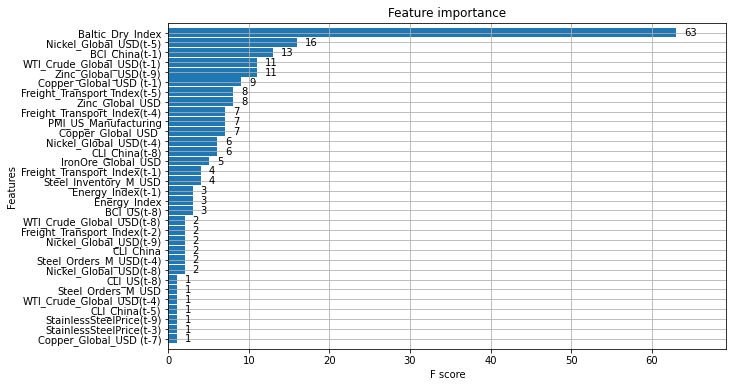

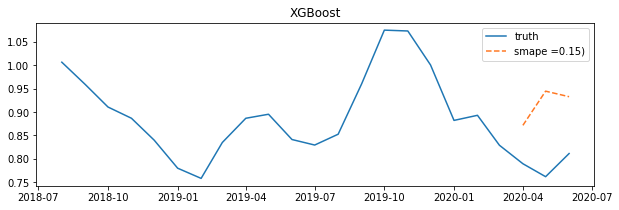

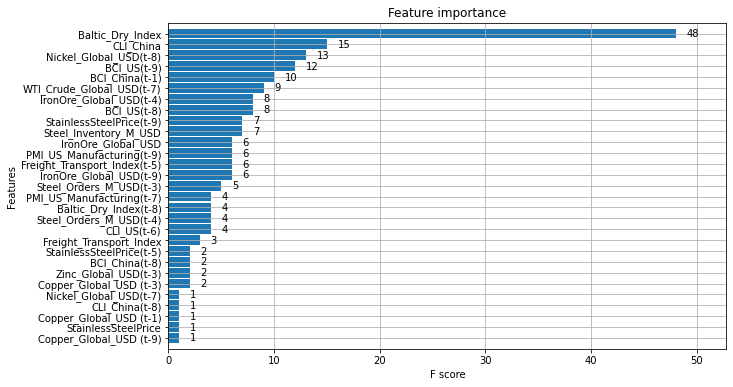

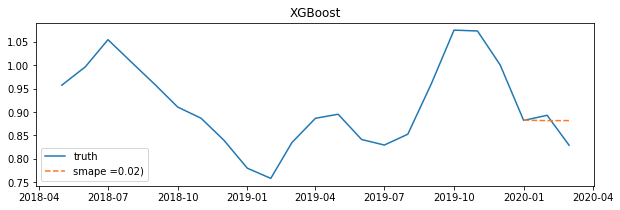

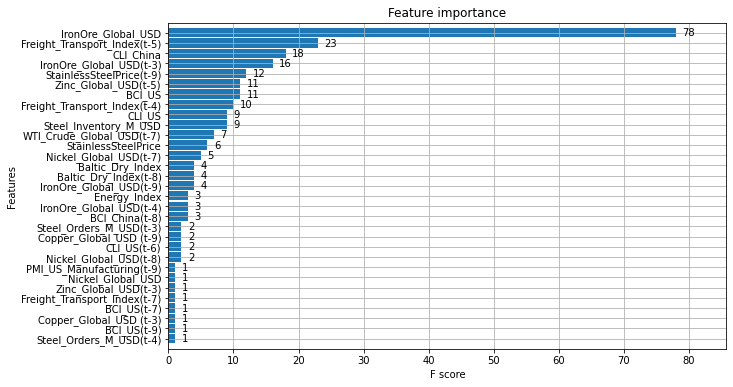

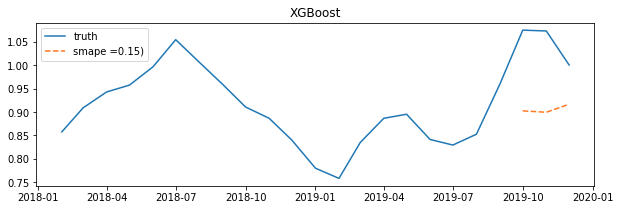

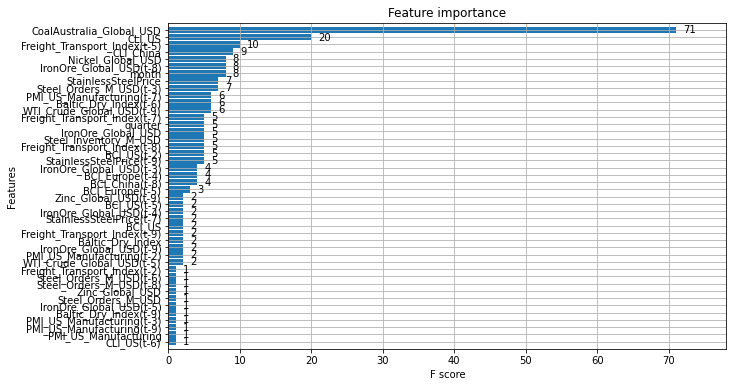

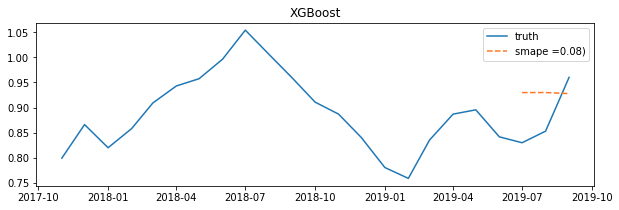

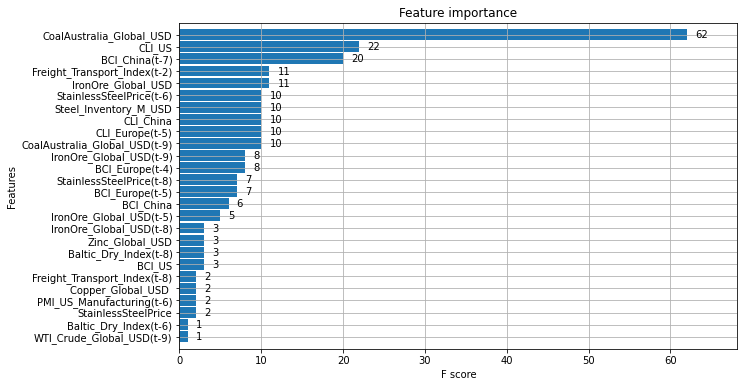

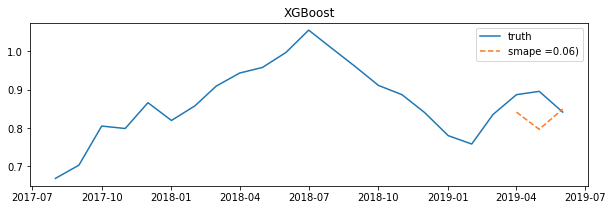

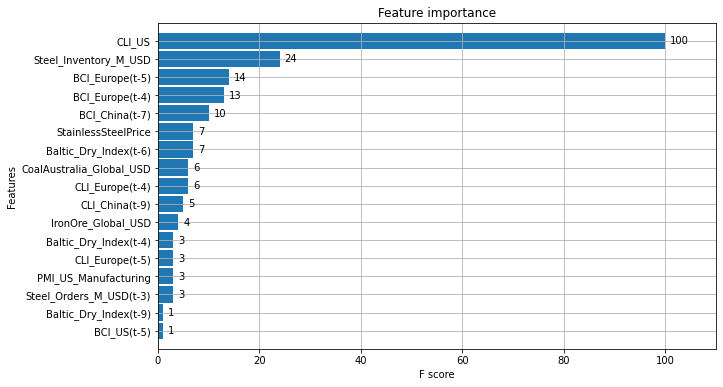

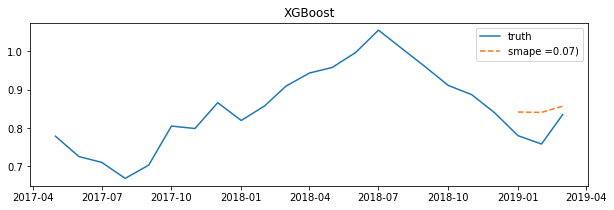

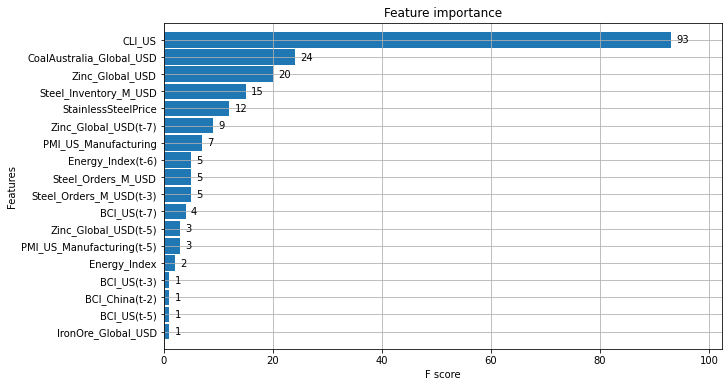

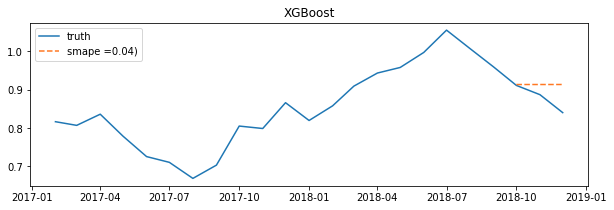

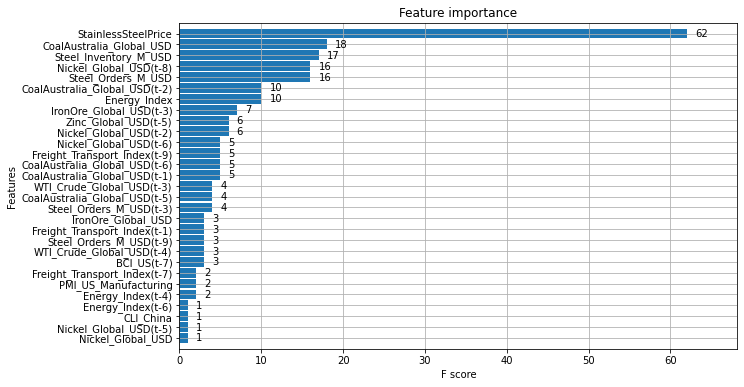

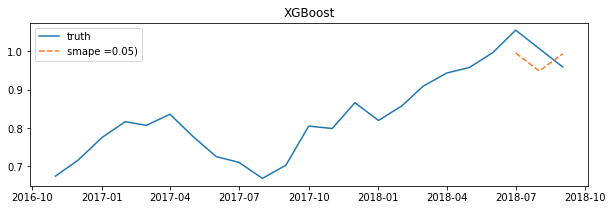

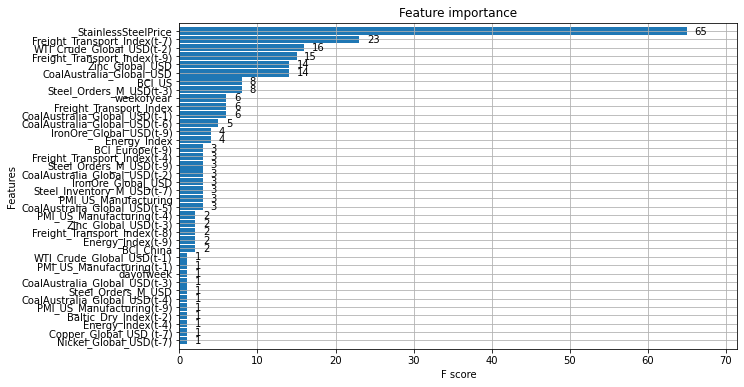

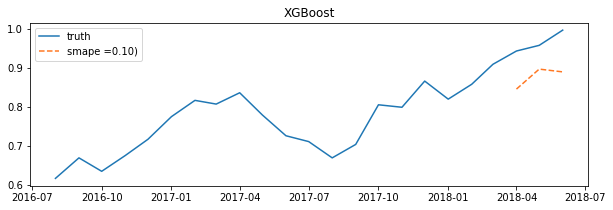

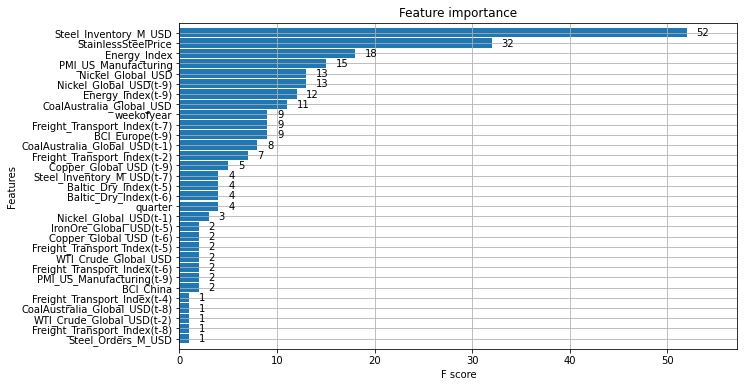

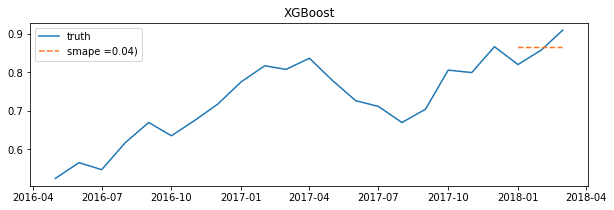

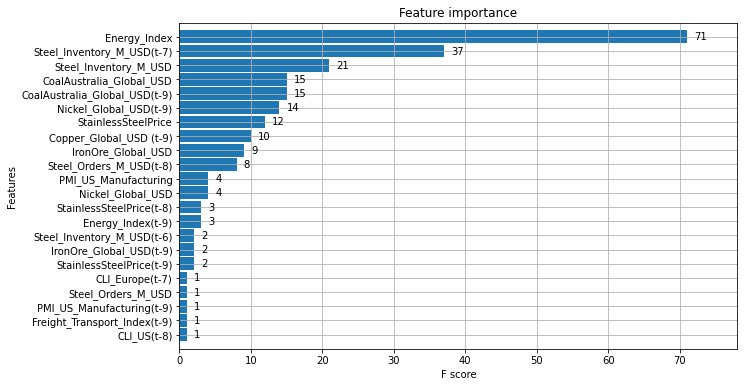

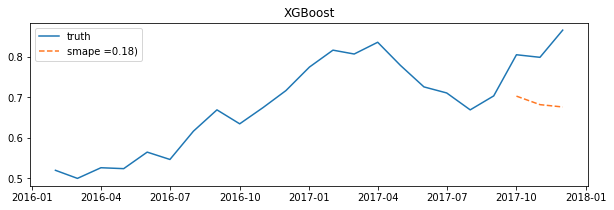

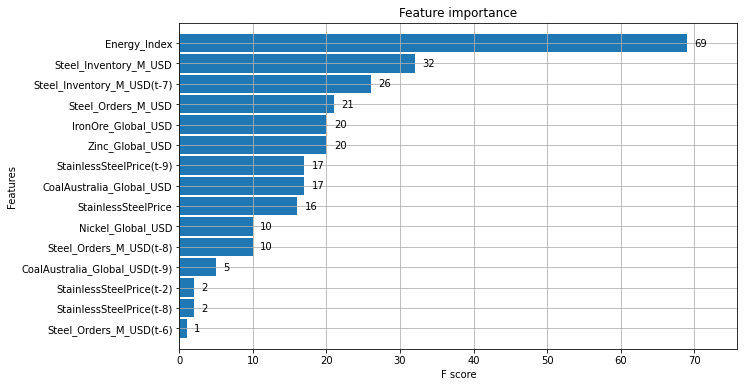

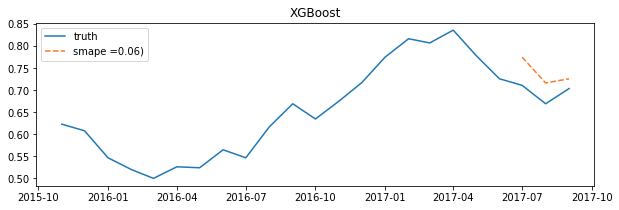

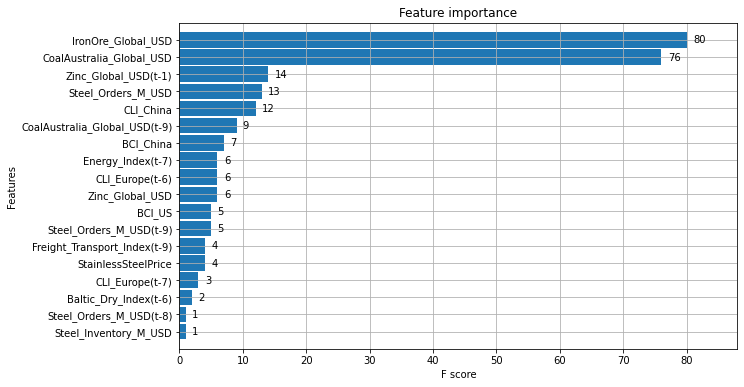

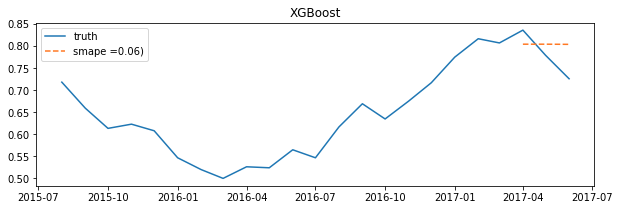

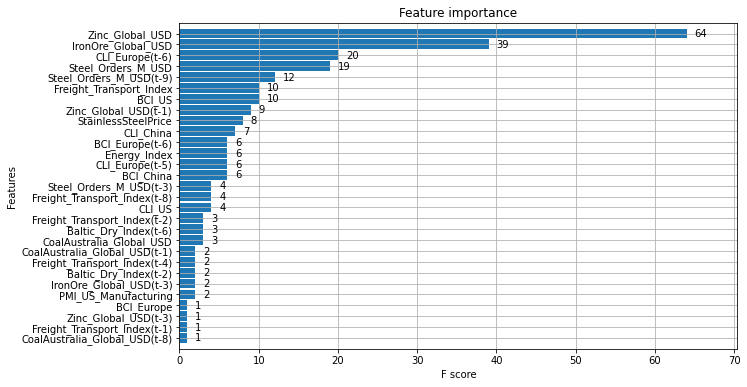

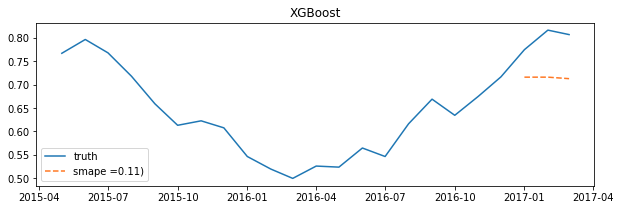

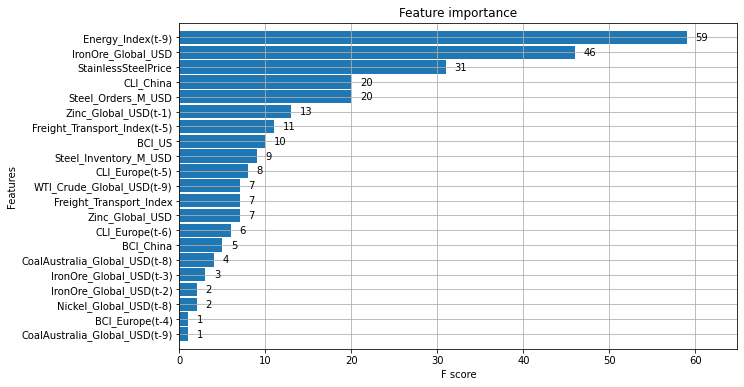

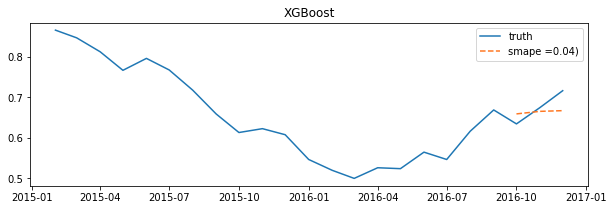

In [68]:
print('lets plot the forecasting results for the optimized setting:')

m,l = run_xgboost_cv(df,horizon=3, num_folds=15, train_length=TRAIN_LEN, lag=LAG, target = target, metric=metric, plot = True, growing_win=False, plot_imp=True)
print(m)